**Challenge: Implement a Multiclass Classification Neural Network using PyTorch**

Objective:
Build a neural network using PyTorch to predict handwritten digits of MNIST.

Steps:

1. **Data Preparation**: Load the MNIST dataset using ```torchvision.datasets.MNIST```. Standardize/normalize the features. Split the dataset into training and testing sets using, for example, ```sklearn.model_selection.train_test_split()```. **Bonus scores**: *use PyTorch's built-* ```DataLoader``` *to split the dataset*.

2. **Neural Network Architecture**: Define a simple feedforward neural network using PyTorch's ```nn.Module```. Design the input layer to match the number of features in the MNIST dataset and the output layer to have as many neurons as there are classes (10). You can experiment with the number of hidden layers and neurons to optimize the performance. **Bonus scores**: *Make your architecture flexibile to have as many hidden layers as the user wants, and use hyperparameter optimization to select the best number of hidden layeres.*

3. **Loss Function and Optimizer**: Choose an appropriate loss function for multiclass classification. Select an optimizer, like SGD (Stochastic Gradient Descent) or Adam.

4. **Training**: Write a training loop to iterate over the dataset.
Forward pass the input through the network, calculate the loss, and perform backpropagation. Update the weights of the network using the chosen optimizer.

5. **Testing**: Evaluate the trained model on the test set. Calculate the accuracy of the model.

6. **Optimization**: Experiment with hyperparameters (learning rate, number of epochs, etc.) to optimize the model's performance. Consider adjusting the neural network architecture for better results. **Notice that you can't use the optimization algorithms from scikit-learn that we saw in lab1: e.g.,** ```GridSearchCV```.


Solaire of Astora here, \\[T]/

This is **not** my first rodeo, not to brag but I myself have trained a lot of models soo... let's see if I can make a massacre out of MNIST for the hundredth time.

Let's first import our tools.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T # We'll need this one for a lil party trick.
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset, Dataset

import tqdm
import random
import numpy as np
from matplotlib import pyplot as plt

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First let's prepare our data, we split into train, valid, and test of course (using seed for reproducibility)

In [2]:
underlying_dataset = MNIST("downloads", train=True, download=True, transform=T.ToTensor())

indexes = list(range(len(underlying_dataset)))
random.seed(42)
random.shuffle(indexes)

n_train = int(len(indexes) * .9)
underlying_train_dset = Subset(underlying_dataset, indexes[:n_train])
underlying_valid_dset = Subset(underlying_dataset, indexes[n_train:])

underlying_test_dset = MNIST("downloads", train=False, download=True, transform=T.ToTensor())

print(n_train, len(indexes) - n_train, len(underlying_test_dset))

54000 6000 10000


As I want to normalize the inputs, let's first calculate mean and standard deviation from the training set.

In [3]:
# images = []
# for img, _ in underlying_train_dset:
#     images.append(img)
#
# images = torch.stack(images)
#
# print(images.mean(), images.std())
## 0.1306, 0.3081

In [4]:
class MyDataset(Dataset):
    def __init__(self, underlying_data, transform):
        self.data = underlying_data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image, label = self.data[idx]
        image = self.transform(image)
        return (image, label)

This is the neat trick that'll help us- the elastic transform! It distorts images and, in this specific case, is great as it represents those little inconsistencies that we make when writing.

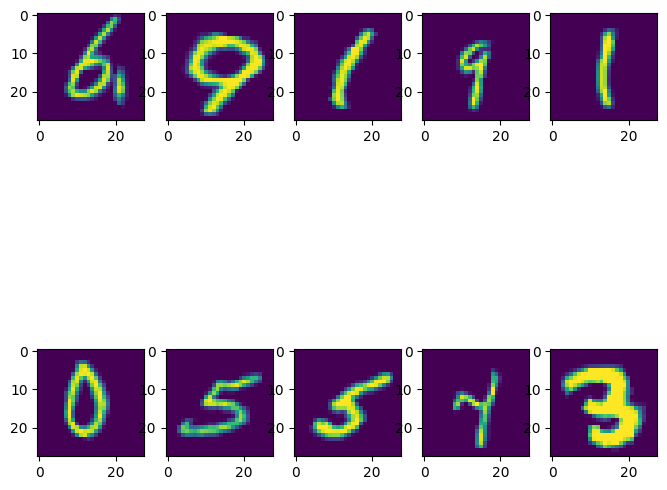

In [5]:
elastic = T.ElasticTransform()

fig=plt.figure(figsize=(8, 8))
for i in range(10):
    a = underlying_train_dset[i][0]
    a = elastic(a)[0]
    fig.add_subplot(2, 5, i+1)
    plt.imshow(a)

plt.show()

In [6]:
train_transform = T.Compose([
    T.ElasticTransform(),
    T.Normalize(0.1306, 0.3081)
])

valid_test_transform = T.Normalize(0.1306, 0.3081)

train_dset = MyDataset(underlying_train_dset, train_transform)
valid_dset = MyDataset(underlying_valid_dset, valid_test_transform)
test_dset = MyDataset(underlying_test_dset, valid_test_transform)

We now write our model; normally I'd use a CNN, but it is required to build a Feed Forward NN so I'll comply-

In [7]:
class Classifier(nn.Module):
    def __init__(self, layers=[(128, 0), (128, .5), (128, .5)], classes=10):

        assert len(layers) > 0

        super().__init__()

        prev_dims = 28 * 28
        modules = []

        for dims, p in layers:
            
            ll = nn.Linear(prev_dims, dims)

            nn.init.kaiming_normal_(ll.weight, a=.1, mode="fan_out", nonlinearity="leaky_relu")
            nn.init.constant_(ll.bias, 0)

            bn = nn.BatchNorm1d(dims)

            nn.init.constant_(bn.weight, 1)
            nn.init.constant_(bn.bias, 0)

            modules.append(ll)
            modules.append(nn.LeakyReLU(.1, True))
            modules.append(bn)
            modules.append(nn.Dropout(p, True))

            prev_dims = dims

        ll = nn.Linear(prev_dims, classes)
        nn.init.kaiming_normal_(ll.weight, mode="fan_out", nonlinearity="linear")
        nn.init.constant_(ll.bias, 0)

        modules.append(ll)

        self.pred = nn.Sequential(*modules)

    def forward(self, x):
        return self.pred(x.flatten(1))
    
# Test
model = Classifier()
print(sum([p.numel() for p in model.parameters()]))

fake_in = torch.randn((32, 1, 28, 28))
fake_out = model(fake_in)
print(fake_out.shape)

del model
del fake_in
del fake_out

135562
torch.Size([32, 10])


Now that we've defined our model, let's define a small training loop:

In [8]:
def train(lr, wd, batch_size, epochs, train_dset=train_dset, valid_dset=valid_dset, layers=[(128, 0), (128, .5), (128, .5)]):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    torch.random.manual_seed(42)
    train = DataLoader(train_dset, batch_size, shuffle=True)
    valid = DataLoader(valid_dset, batch_size, shuffle=False)

    model = Classifier(layers).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    # This scheduler is essentially useless as we do few epochs.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=.1, patience=3, threshold=.2, min_lr=1e-6)

    criterion = nn.CrossEntropyLoss(reduction="none") # We set to none as we want to do calculate a mean at our own pace (an average of averages != an average of all the values).

    pbar = tqdm.tqdm()

    tot_train = len(train_dset)
    train_accus = []
    valid_accus = []

    best_accu = 0

    for epoch in range(epochs):
        losses = []
        accus = []

        model.train()

        pbar.set_description_str(f"Train {epoch + 1:02d}", refresh=False)
        pbar.reset(tot_train)
        
        for img, target in train:
            img = img.to(device)
            target = target.to(device)

            pred = model(img)

            loss = criterion(pred, target)
            loss.mean().backward()

            optimizer.step()
            optimizer.zero_grad()

            accu = (pred.argmax(-1) == target).float()

            losses.extend(loss.detach().cpu().tolist())
            accus.extend(accu.detach().cpu().tolist())

            if len(losses) >= tot_train * .1:
                mean_loss = torch.tensor(losses).mean().item()
                mean_accu = torch.tensor(accus).mean().item()
                pbar.set_postfix_str(f"loss={mean_loss:.3f}, accu={mean_accu:.3f}", refresh=False)
                losses.clear()
                accus.clear()
                train_accus.append(mean_accu)

            pbar.update(img.shape[0])
        
        model.eval()

        with torch.no_grad():
            losses = []
            accus = []

            for img, target in valid:
                img = img.to(device)
                target = target.to(device)

                pred = model(img)

                loss = criterion(pred, target)

                accu = (pred.argmax(-1) == target).float()

                losses.extend(loss.cpu().tolist())
                accus.extend(accu.cpu().tolist())

            mean_loss = torch.tensor(losses).mean().item()
            mean_accu = torch.tensor(accus).mean().item()
            print(f"Valid {epoch +1:02d}: loss={mean_loss:.3f}, accu={mean_accu:.3f}")

            valid_accus.append(mean_accu)
            scheduler.step(mean_accu)

            if best_accu < mean_accu:
                best_accu = mean_accu
    
    return model, train_accus, valid_accus, best_accu


Let's run a hyperparameter grid search. We'll find learning rate and weight decay only on the first epoch. Then we'll try a couple of different hidden layer combinations on the best results for 5 epochs! (I've commented this cell out and left only the training for the best values as it takes a while to run everything)

In [9]:
# lrs = [1e-1, 1e-2, 1e-3, 1e-4]
# wds = [1e-3, 1e-4, 1e-5, 0]
# best_result = (lrs[0], wds[0], 0)

# for lr in lrs:
#     for wd in wds:
#         _, _, _, accu = train(lr, wd, 32, 1)
#         if best_result[-1] < accu:
#             best_result = (lr, wd, accu)


# possible_layers = [
#     [(128, 0), (128, .5), (128, .5)],
#     [(16, 0), (16, .5), (16, .5)],
#     [(256, 0), (256, .5), (256, .5)],
#     [(256, 0), (128, .5), (64, .5)]
# ]

# lr, wd, _ = best_result

# best_result = (possible_layers[0], None, 0)

# for layers in possible_layers:
#     model, _, _, accu = train(lr, wd, 32, 5, layers=layers)
#     if best_result[-1] < accu:
#         best_result = (layers, model, accu)


# print(f"best: lr={lr}, wd={wd}, layers={best_result[0]}, accu={best_result[2]:.3f}")

## best: lr=0.01, wd=1e-05, layers=[(128, 0), (128, 0.5), (128, 0.5)], accu=0.973

model, _, _, accu = train(0.01, 1e-05, 32, 5, layers=[(128, 0), (128, 0.5), (128, 0.5)])

Train 02:   0%|          | 64/54000 [00:00<01:52, 480.01it/s, loss=0.541, accu=0.835]   

Valid 01: loss=0.201, accu=0.941


Train 03:   0%|          | 64/54000 [00:00<01:56, 464.34it/s, loss=0.407, accu=0.879]   

Valid 02: loss=0.147, accu=0.956


Train 04:   0%|          | 64/54000 [00:00<01:49, 491.25it/s, loss=0.382, accu=0.884]   

Valid 03: loss=0.119, accu=0.966


Train 05:   0%|          | 64/54000 [00:00<01:59, 452.63it/s, loss=0.321, accu=0.909]   

Valid 04: loss=0.114, accu=0.967


Train 05: 100%|██████████| 54000/54000 [02:07<00:00, 424.73it/s, loss=0.310, accu=0.908]

Valid 05: loss=0.095, accu=0.973


Now we've got a somewhat good model (it takes a while to run models on a mere CPU ok? I can't try every combination >:P) so let's test it.

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

test = DataLoader(test_dset, 32, shuffle=False)

model.eval()
preds = []
targs = []

with torch.no_grad():
    for img, target in test:
        img = img.to(device)
        target = target.to(device)

        pred = model(img)

        preds.extend(pred.argmax(-1).tolist())
        targs.extend(target.tolist())

    mean_accu = (torch.tensor(preds) == torch.tensor(targs)).float().mean().item()
    print(f"Test: accu={mean_accu:.3f}")

Test: accu=0.973


This dataset is balanced, therefore accuracy should be a fairly good metric- yet since this is a multi-class classification task it would be better to check the performance through a confusion matrix, which should give us all the insights we need.

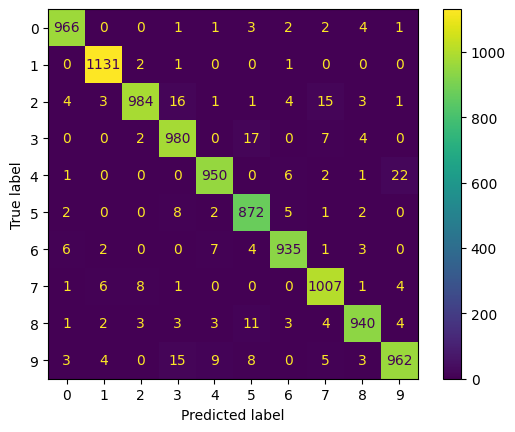

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

res = confusion_matrix(targs, preds)

disp = ConfusionMatrixDisplay(res, display_labels=range(10))
disp.plot()
plt.show()

Nice.
I don't have much to say other than this, the matrix speaks for itself, other than a couple of outliers we managed to achieve a pretty impressive result...

But, if I have to be slightly critic, the MNIST challenge is quite outdated and, as shown here, can be solved with quite little effort (and it has been done since 1998 by [LeCun](http://yann.lecun.com/exdb/mnist/)!). In my opinion, a good starting dataset should otherwise be FashionMNIST, which is a drop-in replacement for MNIST but gives a slightly bigger challenge.

Anyway, enough of this rant- Solaire of Astora out, have a good day!